# modeling

In [1]:

import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = wr.get_clean_data(start2018=False)
sdf = s.get_summary_df(df)
sdf = wr.add_date_features(sdf)

In [7]:
df.shape

(261886, 20)

In [8]:
df.groupby(lambda x: x.year).size()

order_date
2018    55843
2019    63452
2020    66299
2021    49931
2022    26361
dtype: int64

### Spit For modeling

In [10]:
train, test = wr.split_data(df)

<AxesSubplot:xlabel='order_date'>

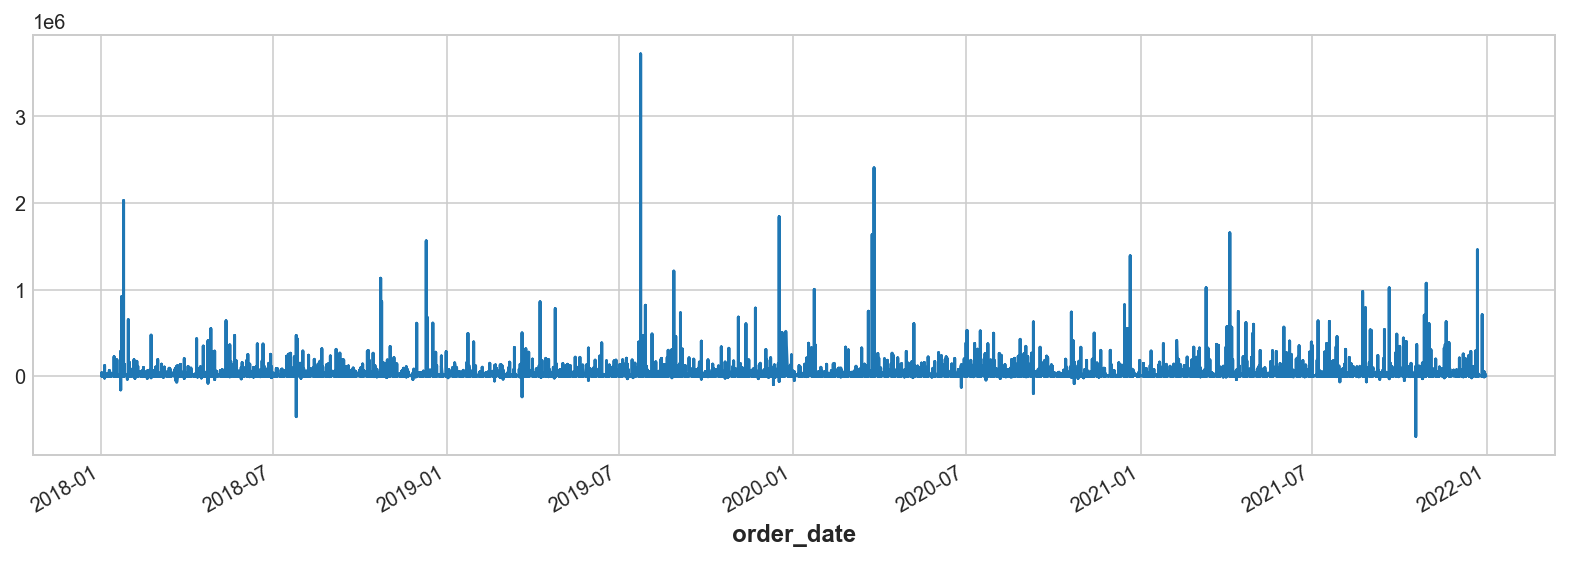

In [12]:
train.purchase_amount.plot()

In [10]:
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

In [11]:
pd.concat([validate.tail(1), test.head(1)])

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,month_name,day_name,year,quarter,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2022-06-30,Texas Parks and Wildlife Department,State Agency,Austin,"Presidio Networked Solutions Group, LLC",Irving,"78,744.00",8.00,50.12,20520,2022-07-19,2022-06-30,June,Thursday,2022,2,6,26,3,181,400.96
2022-07-01,City of Cleburne,Local Government,Cleburne,"Sequel Data Systems, Inc.",Austin,76031,1.00,432.90,0138-06302022-01,2022-07-06,2022-07-01,July,Friday,2022,3,7,26,4,182,432.90


In [12]:
X_train = pd.DataFrame(train.purchase_amount.copy().resample('D').sum())
X_validate = pd.DataFrame(validate.purchase_amount.copy().resample('D').sum())
X_test = pd.DataFrame(test.purchase_amount.copy().resample('D').sum())

In [ ]:
ts = X_train.copy()
ts.plot()

In [ ]:
baseline = X_train.purchase_amount.mean()

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(X_train)
plt.plot(X_validate)
plt.plot(X_test)
plt.ylabel(col)
plt.title(col)
plt.show()


### evaluate

In [ ]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [ ]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [ ]:
# empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


In [ ]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average

In [ ]:
# compute simple average
purchase_amount = round(X_train.purchase_amount.mean(), 2)
purchase_amount

In [ ]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'purchase_amount': [purchase_amount],},
                          index=X_validate.index)
    return yhat_df

In [ ]:
yhat_df = make_predictions(purchase_amount)
yhat_df.head()

In [ ]:
mean_squared_error(X_validate.purchase_amount, yhat_df.purchase_amount)

In [ ]:
plot_and_eval("purchase_amount")

In [ ]:
eval_df = append_eval_df(model_type='simple_averave', 
                        target_var = 'purchase_amount')
eval_df

In [ ]:
X_train.shape

# Final Model

In [3]:
# Model.py

In [5]:
def change_ts(train_ts):
    '''
    removes pandemic data from 2019 and 2020
    Parameters:
        train_ts: train time series
    '''
    before = train_ts.loc[:'2019-06'].copy()
    after = train_ts.loc['2020-07':].copy()
    # one extra day because of the leap year 2020
    before.index = (before.index + pd.Timedelta('1 Y') + pd.Timedelta('1 D')).normalize()

    train_new =  pd.concat([before, after], axis=0)

    #train_new.index = pd.DatetimeIndex(train_new.index).to_period('D')

    return train_new

In [14]:
import pandas as pd
import numpy as np

# models
import statsmodels.api as sm
import xgboost as xgb
# pmdarima and prophet need installation!
#import pmdarima as pm # pip install pmdarima
#import prophet # python -m pip install prophet
#from prophet import Prophet
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima.utils import ndiffs

from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import helper modules
import src.wrangle as wr
import src.summaries as s

# import graphic modules
import matplotlib.pyplot as plt
import seaborn as sns
# set default parameters
plt.style.use("seaborn-whitegrid") # returns warnings
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.rcParams.update({'figure.dpi':120})
#%config InlineBackend.figure_format = 'retina'

# set default parameters for floats
pd.options.display.float_format = '{:,.2f}'.format

start2018_ = wr.get_start2018()
##### get the data
df = s.get_summary_df(wr.get_clean_data())
df = wr.drop2017_and_move2016_up(df)
# define target vaiable
target = 'purchase_amount'
#### split into train, validate, test sets
train, test = wr.split_data(df)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':].copy()
# get time series with the daily resample
X_train_ts = train.purchase_amount.copy().resample('D').sum()
X_validate_ts = validate.purchase_amount.copy().resample('D').sum()
X_test_ts = test.purchase_amount.copy().resample('D').sum()
# data frames out of the TS
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()

# prepare data to use with Prophet
pr_train = X_train.reset_index()
pr_train.columns = ['ds', 'y']
pr_validate = X_validate.reset_index()
pr_validate.columns = ['ds', 'y']

# prepare data to use with XGBOOST
X_train_xgb = wr.add_date_features(X_train.copy())
X_validate_xgb = wr.add_date_features(X_validate.copy())
X_test_xgb = wr.add_date_features(X_test.copy())

features = ['month', 'week', 'day_of_week', 'year','day_of_year']

y_train = X_train_xgb.purchase_amount
y_validate = X_validate_xgb.purchase_amount
y_test = X_test_xgb.purchase_amount

X_train_xgb = X_train_xgb[features]
X_validate_xgb = X_validate_xgb[features]
X_test_xgb = X_test_xgb[features]
# cut pandemic 
X_train_ts =  change_ts(X_train_ts)
# data frames to keep predictions
predictions_train = X_train[target].to_frame()
predictions_validate = X_validate[target].to_frame()
# data frame to keep scores
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

baseline = 654_835.73
baseline = X_train_ts.mean()
# add baseline values to predictions
predictions_train['baseline'] = baseline
predictions_validate['baseline'] = baseline

def show_ts():
    '''
    plots daily sales for the X_train
    '''
    plt.figure(figsize = (11,4))
    ax  = X_train_ts.plot(alpha=0.7)
    plt.title('Data Merge')
    ax.set(yticks=[0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000])
    ax.set(yticklabels=['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
    plt.show()

def evaluate(target_name: str = target, model_name: str = 'baseline'):
    '''
    Calculate RMSE score for train and validate predictions,
    store RMSE into scores data frame,
    plots the predictions vs actual values
    Parameters:
        target_name: str, target variable
        model_name: str, model name, should match the column name 
                    in prediction data frame where values are stored
    Returns:
        no returns
    '''
    RMSE_train = round(np.sqrt(mean_squared_error(X_train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(X_validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
    # plot
    plt.figure(figsize = (12,4))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.legend()
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

def evaluate_rmse(target_name:str, model_name: str, train=True):
    '''
    Calculate RMSE score for train and validate predictions,
    store RMSE into scores data frame,
    Parameters:
        target_name: str, target variable
        model_name: str, model name, should match the column name 
                    in prediction data frame where values are stored
        train: bool, True if train set has to be evaluated
    Returns:
        no returns
    '''
    if train:
        RMSE_train = round(np.sqrt(mean_squared_error(predictions_train[target_name], predictions_train[model_name])))
        RMSE_validate = round(np.sqrt(mean_squared_error(predictions_validate[target_name], predictions_validate[model_name])))
        scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    else:
        RMSE_validate = round(np.sqrt(mean_squared_error(predictions_validate[target_name], predictions_validate[model_name])))
        scores.loc[len(scores)] = [model_name, None, RMSE_validate]
    
def plot_model(target_name: str, model_name: str):
    '''
    Plots the predictions vs actual values
    Parameters:
        target_name: str, target variable
        model_name: str, model name, should match the column name 
                    in prediction data frame where values are stored
    Returns:
        no returns
    '''
    plt.figure(figsize = (10,6))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

def moving_average(span=2):
    '''
    Create moving averages.
    Saves results to predictions_train and predictions_validate
    Evaluate results and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # assign the period for the moving average
    span = span
    # identify the model
    model_name = 'Moving Average' + ' ' + str(span)
    # create a baseline value of moving average
    ma_baseline = round(X_train.purchase_amount.rolling(span).mean()[-1], 2)
    
    # rolling amounts to fill train and validate sets
    rolling_amount_train = round(X_train.purchase_amount.rolling(span).mean(), 2).fillna(ma_baseline)
    rolling_amount_validate = round(X_validate.purchase_amount.rolling(span).mean(), 2)
    # slicing index to replace the indexes in the beginning of validation set with the last values of train set
    temp_index = span - 1
    # put rolling moving average values to the predictions train
    predictions_train[model_name] = rolling_amount_train
    # replace validate nulls with last values of train set
    rolling_amount_validate[:temp_index] = predictions_train[model_name][-temp_index:].values
    # put predictions into predictions validate
    predictions_validate[model_name] = rolling_amount_validate
    # evaluate and save results into scores data frame
    evaluate_rmse(target, model_name)

def exponential_moving_average(span=3):
    '''
    Create exponential moving averages.
    Saves results to predictions_train and predictions_validate
    Evaluate results and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # identify the model
    model_name = 'Exp Moving Average' + ' ' + str(span)
    predictions_train[model_name] = X_train.ewm(span=span).mean()
    predictions_validate[model_name] = X_validate.ewm(span=span).mean()
    evaluate_rmse(target, model_name)

def show_ma_baseline_scores(min_limit:int = 2, max_limit:int = 2):
    '''
    Calulates MA (moving average) and EMA (exponential moving average).
    Display scores data frame
    Parameters:
        min_limit: int, minimum value of spans(periods) for MA and EMA
        max_value: int, minimum value of spans(periods) for MA and EMA
    Returns:
        void
        * We already know that the best scores are for the span=2, 
        so we set deafault limits as 2.
    '''
    evaluate_rmse(target, 'baseline')
    for i in range(min_limit, max_limit+1):
        moving_average(i)
        exponential_moving_average(i)
        display(scores)

#### ARIMA MODEL
def model_arima(p:int=1, d:int=0, q:int=0, show_viz:bool=False):
    '''
    Create ARIMA model, fit results to train time series, predict validate time series
    Evaluate results
    Plot the predictions for the validate set agains the actual value by request
    Parameters are parameters for ARIMA model:
        p: int, the number of lag observations in the model, also known as the lag order. 
        d: int, the number of times the raw observations are differenced; also known as the degree of differencing. 
        q: int, the size of the moving average window, also known as the order of the moving average.
        show_viz: bool. if True - plots predictions
    * default parameters for daily predictions are set to 1, 0, 0
    1 - the only lag that has correlation is 1 day
    0 - data is stationary, no trend
    0 - no MA window
    '''
    # create ARIMA model
    model = ARIMA(X_train_ts, order=(p, d, q))
    # model name to save predictions 
    model_name = f'ARIMA {p},{d},{q}'
    fit = model.fit()
    forecast = fit.forecast(len(X_validate_ts))
    predictions_validate[model_name] = forecast
    evaluate_rmse(target, model_name, train=False)
    if show_viz:
        X_validate_ts.plot(alpha = 0.3)
        forecast.plot(label='predictions', alpha=0.3)
        predictions_validate.baseline.plot(label='Baseline', ls='--')
        predictions_validate['Exp Moving Average 2'].plot(label='Exponential MA')
        plt.title(f'Predictions of {model_name}')
        plt.legend()
        plt.show()

def create_arima_models():
    model_arima()
    model_arima(2, 0, 0)
    model_arima(0, 0, 2)
    model_arima(0, 0, 5)
    display(scores)



def run_xgboost():
    '''
    Creates the XGBoost Regression model
    Saves predictions to prediction data frames
    Evaluates the model performance
    '''

    xgb_model = xgb.XGBRegressor(n_estimators = 500, 
                             early_stopping_rounds = 25,
                             learning_rate=0.01, verbosity=0)
    XG, yxg = wr.change_XGB_train(X_train_xgb, y_train)
    xgb_model.fit(XG, yxg, eval_set = [(XG, yxg), (X_validate_xgb, y_validate)], verbose=False)
    predictions_train['XGBoost'] = xgb_model.predict(X_train_xgb)
    predictions_validate['XGBoost'] = xgb_model.predict(X_validate_xgb)
    
    evaluate_rmse(target, 'XGBoost')
    display(scores)

###### run XGBoost on test set



def run_test_model(save_results=False):
    '''
    Calls get_prophet_data to get train and validate sets
    Creates prophet model
    Saves forecasts to train and test sets
    Parameters:
        df: cleaned original or summary data frame
    Returns:
        pr_train: pd.DataFrame with original data, baseline and predictions
        pr_test: pd.DataFrame with original data, baseline and predictions
    '''

    xgb_model = xgb.XGBRegressor(n_estimators = 500, 
                             early_stopping_rounds = 25,
                             learning_rate=0.01, verbosity=0)
    XG, yxg = wr.change_XGB_train(X_train_xgb, y_train)
    xgb_model.fit(XG, yxg, eval_set = [(XG, yxg), (X_validate_xgb, y_validate)], verbose=False)
    # make forecast for the train set

    # save forecast to prediction data frame and evaluate them

    forecast = xgb_model.predict(X_test_xgb)

    X_test_xgb['y'] = y_test
    X_test_xgb['baseline'] = baseline
    X_test_xgb['forecast'] = forecast
    if save_results:
        X_test_xgb.to_pickle('predictions.pickle')
    RMSE_prohet = np.sqrt(mean_squared_error(X_test_xgb.y, X_test_xgb.forecast))
    RMSE_baseline = np.sqrt(mean_squared_error(X_test_xgb.y, X_test_xgb.baseline))
    # set model name as an index in scores data frame
    scores.set_index('model_name', inplace=True)
    test_scores = pd.DataFrame({
                         'Baseline':[ scores.loc['baseline', 'train_score'], 
                                     scores.loc['baseline', 'validate_score'], RMSE_baseline],
                         'XGBoost':[ scores.loc['XGBoost', 'train_score'],
                                    scores.loc['XGBoost', 'validate_score'], RMSE_prohet]
                            },index=[ 'Train RMSE', 'Validate RMSE', 'Test RMSE'])
    
    display(test_scores)
    #plot predictions
    sns.set_style("whitegrid")
    plt.figure(figsize = (12,4))
    ax = sns.lineplot(data=X_test_xgb, x=X_test_xgb.index, y='y', label='Actual values')
    ax = sns.lineplot(data=X_test_xgb, x=X_test_xgb.index, y='forecast', label='Model forecast')
    ax = sns.lineplot(data=X_test_xgb, x=X_test_xgb.index, y='baseline', label='Baseline predictions')
    ax.set(title='XGBoost predictions on the test set')
    ax.set(yticks=[0, 500_000, 2_000_000, 3_500_000])
    ax.set(yticklabels=['0', '500K', '2M', '3.5M'])
    ax.set(ylabel='purchase_amount')
    plt.show()

def save_validate_predictions():
    '''
    saves the predictions of validate set into file
    '''
    predictions_validate.to_pickle('validate.pickle')

def estimate():
    '''
    calculates the sum of actual purchase amount and predictions
    '''
    X = pd.read_pickle('predictions.pickle')
    actual_sum = X.y.sum()
    baseline_results = X.baseline.sum()
    forecast_results = X.forecast.sum()
    d = {'actual purchase amount': actual_sum,
            ' baseline predidtions':baseline_results,
        'model predictions': forecast_results,
        'difference': forecast_results - actual_sum}
    return pd.DataFrame(d, index=['Amount in USD']).T

In [15]:
run_test_model(save_results=True)

KeyError: 'baseline'

In [16]:
##### get the data
df = s.get_summary_df(wr.get_clean_data(start2018=True))
#### split into train, validate, test sets
train, test = wr.split_data(df)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':].copy()
# get time series with the daily resample
X_train_ts = train.purchase_amount.copy().resample('D').sum()
X_validate_ts = validate.purchase_amount.copy().resample('D').sum()
X_test_ts = test.purchase_amount.copy().resample('D').sum()
# data frames out of the TS
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()

In [17]:
X_train = wr.add_date_features(X_train)
X_validate = wr.add_date_features(X_validate)
X_test = wr.add_date_features(X_test)

In [18]:
features = ['month', 'week', 'day_of_week', 'year','day_of_year']
target = 'purchase_amount'

In [20]:
X_train.head(10)

,purchase_amount,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name
order_date,,,,,,,,,
2018-01-02,"171,192.78",2018,1,1,1,1,2,January,Tuesday
2018-01-03,"102,080.14",2018,1,1,1,2,3,January,Wednesday
2018-01-04,"181,355.01",2018,1,1,1,3,4,January,Thursday
2018-01-05,"1,029,700.32",2018,1,1,1,4,5,January,Friday
2018-01-06,"41,740.42",2018,1,1,1,5,6,January,Saturday
2018-01-07,0.00,2018,1,1,1,6,7,January,Sunday
2018-01-08,"175,369.33",2018,1,1,2,0,8,January,Monday
2018-01-09,"180,253.62",2018,1,1,2,1,9,January,Tuesday
2018-01-10,"595,869.88",2018,1,1,2,2,10,January,Wednesday


In [22]:
# data frame to keep scores
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

In [23]:
xgboost_regular_model = xgb.XGBRegressor(n_estimators = 1000, 
                         early_stopping_rounds = 50,
                         learning_rate=0.01)
xgboost_regular_model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_validate, y_validate)],
         verbose = 10)

[0]	validation_0-rmse:1089079.37500	validation_1-rmse:946044.43750
[10]	validation_0-rmse:1032910.75000	validation_1-rmse:900857.18750
[20]	validation_0-rmse:984129.62500	validation_1-rmse:863801.00000
[30]	validation_0-rmse:941701.18750	validation_1-rmse:834340.62500
[40]	validation_0-rmse:905278.50000	validation_1-rmse:811416.62500
[50]	validation_0-rmse:873502.31250	validation_1-rmse:793013.37500
[60]	validation_0-rmse:846589.81250	validation_1-rmse:779999.87500
[70]	validation_0-rmse:823005.75000	validation_1-rmse:770471.37500
[80]	validation_0-rmse:801992.62500	validation_1-rmse:764022.00000
[90]	validation_0-rmse:783969.12500	validation_1-rmse:759935.12500
[100]	validation_0-rmse:768074.43750	validation_1-rmse:757294.00000
[110]	validation_0-rmse:754390.93750	validation_1-rmse:755845.06250
[120]	validation_0-rmse:742363.37500	validation_1-rmse:754851.18750
[130]	validation_0-rmse:731828.12500	validation_1-rmse:754427.00000
[140]	validation_0-rmse:722378.93750	validation_1-rmse:75

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)